In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
import numpy as np
from epi.models import Parameter, Model
from epi.util import pairplot
import tensorflow as tf
from epi.SC_Circuit_4 import SC_acc, SC_acc_diff, SC_acc_var, SC_sim, SC_sim_opto, unwrap
from scipy.special import expit

import os
figdir = "../../written/SC_model/figs/"

c_LP = '#3B8023'
c_LA = '#EA8E4C'
c_RA = '#F4C673'
c_RP = '#81C176'


### 1. Define the V1Circuit model

In [2]:
lb = -5.
ub = 5.

sW = Parameter("sW", 1, lb=lb, ub=ub)
vW = Parameter("vW", 1, lb=lb, ub=ub)
dW = Parameter("dW", 1, lb=lb, ub=ub)
hW = Parameter("hW", 1, lb=lb, ub=ub)

parameters = [sW, vW, dW, hW]

model = Model("SC_Circuit_var", parameters)

In [3]:
p = 0.75
mu_std = 0.05
model.set_eps(SC_acc_var(p))

epi_df = model.get_epi_df()
epi_df['c0'] = [al_hps['c0'] for al_hps in epi_df['AL_hps']]
epi_df['beta'] = [al_hps['beta'] for al_hps in epi_df['AL_hps']]
epi_df['random_seed'] = [al_hps['random_seed'] for al_hps in epi_df['arch']]
epi_df['bnmom'] = [al_hps['bn_momentum'] for al_hps in epi_df['arch']]
epi_df['p'] = [ep['mu'][0] for ep in epi_df['EP']]
epi_df['mu_std'] = [np.sqrt(ep['mu'][2]) for ep in epi_df['EP']]
epi_df['mu_len'] = [ep['mu'].shape[0] for ep in epi_df['EP']]

data/epi/SC_Circuit_var/a2c18082e7d1e33948198182605af211/D4_C3_L2_U50_bnmom=0.00E+00_PA_rs1/fdaf5b31967f59138c9b4e2ff6a1bec4/N100_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta4.00E+00
mu std 0.05
beta 4.0
random seed 1


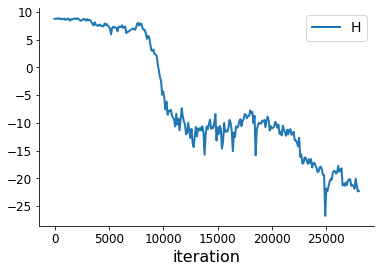

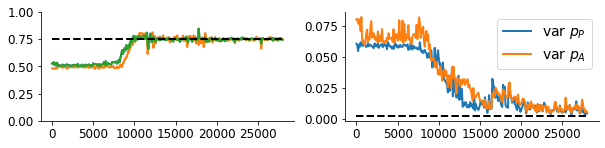

data/epi/SC_Circuit_var/a2c18082e7d1e33948198182605af211/D4_C3_L2_U50_bnmom=0.00E+00_PA_rs2/fdaf5b31967f59138c9b4e2ff6a1bec4/N100_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta4.00E+00
mu std 0.05
beta 4.0
random seed 2


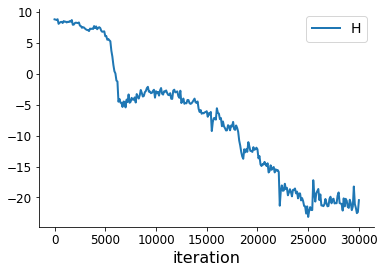

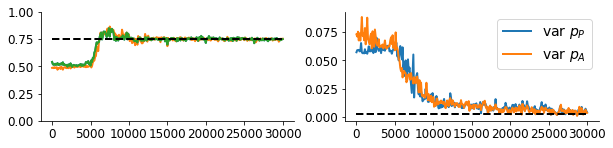

data/epi/SC_Circuit_var/a2c18082e7d1e33948198182605af211/D4_C3_L2_U50_bnmom=0.00E+00_PA_rs3/fdaf5b31967f59138c9b4e2ff6a1bec4/N100_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta4.00E+00
mu std 0.05
beta 4.0
random seed 3


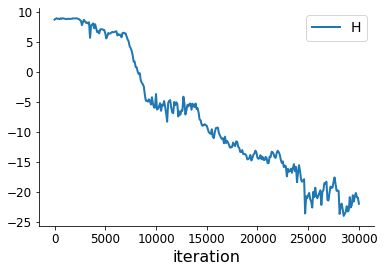

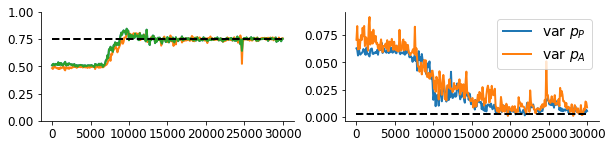

data/epi/SC_Circuit_var/a2c18082e7d1e33948198182605af211/D4_C3_L2_U50_bnmom=0.00E+00_PA_rs4/fdaf5b31967f59138c9b4e2ff6a1bec4/N100_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta4.00E+00
mu std 0.05
beta 4.0
random seed 4


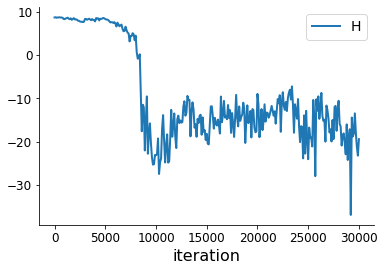

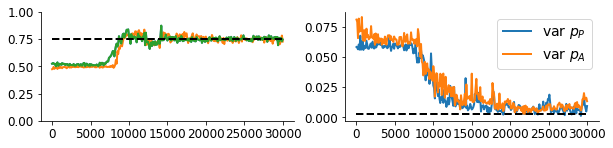

In [4]:
mu =  np.array([p, 1-p, mu_std**2, mu_std**2])
epi_df2 = epi_df[(epi_df['p']==p)
               & (epi_df['bnmom']==0)]
               #& (epi_df['random_seed'] == 2)]
               #& (epi_df['c0']==1e2) 
               #& (epi_df['mu_std']==mu_std) 
               #& (epi_df['mu_len'] == 4)]


paths = sorted(epi_df2['path'].unique())
for i, path in enumerate(paths):
    print(path)
    epi_df2 = epi_df[epi_df['path'] == path]
    print('mu std', epi_df2['mu_std'].iloc[0])
    print('beta', epi_df2['beta'].iloc[0])
    print('random seed', epi_df2['random_seed'].iloc[0])
    epi_df2.plot('iteration', 'H')
    plt.show()
    fig, axs = plt.subplots(1,2,figsize=(10,2))
    Rs = ['R%d' % r for r in range(1,3)]
    axs[0].plot(epi_df2['iteration'], epi_df2['R1'] + mu[0], label=r'$p_P$')
    axs[0].plot(epi_df2['iteration'], 1.-(epi_df2['R2'] + mu[1]), label=r'$p_A$')
    axs[0].plot(epi_df2['iteration'], epi_df2['R1'] + mu[0], label=r'$p_P$')
    axs[0].plot([0, epi_df2['iteration'].max()], [mu[0], mu[0]], 'k--')
    axs[0].set_ylim([0,1])
    axs[1].plot(epi_df2['iteration'], epi_df2['R3'], label=r'var $p_P$')
    axs[1].plot(epi_df2['iteration'], epi_df2['R4'], label=r'var $p_A$')
    axs[1].plot([epi_df2['iteration'].min(), epi_df2['iteration'].max()], [mu_std**2, mu_std**2], 'k--')
    plt.legend()
    plt.show()

In [5]:
"""best_Hs = []
convergeds = []
best_ks = []
nu = 0.5
for i, path in enumerate(paths):
    _epi_df = epi_df[epi_df['path'] == path]
    df_row = _epi_df.iloc[0]
    init = df_row['init']
    init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
    nf = model._df_row_to_nf(df_row)
    aug_lag_hps = model._df_row_to_al_hps(df_row)
    best_k, converged, best_H = model.get_convergence_epoch(init_params, nf, mu, aug_lag_hps, 
                                    alpha=0.05, nu=nu)
    best_Hs.append(best_H)
    convergeds.append(converged)
    best_ks.append(best_k)


bestHs = np.array(best_Hs)
best_ks = np.array(best_ks)

best_Hs = np.array([x if x is not None else np.nan for x in best_Hs])
ind = np.nanargmax(best_Hs)

path = paths[ind]
best_k = int(best_ks[ind])
best_H = best_Hs[ind]"""

Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


KeyboardInterrupt: 

In [61]:
print(best_k)
print(path)

14
data/epi/SC_Circuit_var/a2c18082e7d1e33948198182605af211/D4_C3_L2_U50_bnmom=0.00E+00_PA_rs2/fdaf5b31967f59138c9b4e2ff6a1bec4/N100_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta4.00E+00


In [ ]:
#path = paths[1]
#best_k = 12

0.28516442
0.20009261


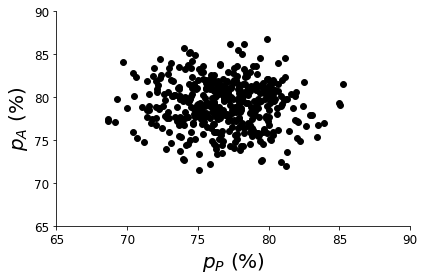

In [20]:
path = paths[1]
best_k = 14
_epi_df = epi_df[epi_df['path'] == path]
df_row = _epi_df.iloc[0]
init = df_row['init']
init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
nf = model._df_row_to_nf(df_row)
aug_lag_hps = model._df_row_to_al_hps(df_row)

dist = model._get_epi_dist(best_k, init_params, nf, mu, aug_lag_hps)

np.random.seed(0)
tf.random.set_seed(0)
z, log_q_z = dist.nf(1)
dist.nf._reset_bn_movings()
z, log_q_z = dist.nf(500)
z = z.numpy()
log_q_z = log_q_z.numpy()
u_t, v_t = SC_sim(*unwrap(z))
T_x = np.mean(expit(100.*(v_t[-1,:,:,0,:] - v_t[-1,:,:,3,:])), axis=2)
plt.scatter(100*(T_x[:,0]), 100.*(1-T_x[:,1]), s=35, c='k')
plt.plot([0,1], [0,1], 'k-')
plt.xlabel(r'$p_P$ (%)', fontsize=20)
plt.ylabel(r'$p_A$ (%)', fontsize=20)
plt.xlim([65, 90])
plt.ylim([65, 90])
#plt.xlim([62.5, 87.5])
#plt.ylim([62.5, 87.5])
plt.tight_layout()
plt.savefig(os.path.join(figdir, "SC_T_x.pdf"))

_lb = np.array([p.lb[0] for p in model.parameters])
_ub = np.array([p.ub[0] for p in model.parameters])
z_labels = [p.name for p in model.parameters]
#plot_inds = np.logical_and(z[:,0] < 5., z[:,1] < 5.)
plot_inds = np.logical_and(
    np.logical_and(z[:,0] < 1., z[:,1] < 0.), 
    np.logical_and(z[:,2] < 0., z[:,3] < -1.25))
plot_inds = np.logical_and(plot_inds, z[:,3]  > -2.)
z_plot = z[plot_inds]
log_q_z_plot = log_q_z[plot_inds]
v_t_plot = v_t.numpy()[:,plot_inds]
u_t_plot = u_t.numpy()[:,plot_inds]
T_x_plot = T_x[plot_inds]

p_stars = [0.7, 0.8]
z_stars = []
z_star_inds = []
for p_star in p_stars:
    #mu_star = np.array([p_star, 1.-p_star])[None,:]
    d = np.square(T_x_plot[:,1]-(1.-p_star))
    min_ind = np.argmin(d)
    print(T_x_plot[min_ind,1])
    z_stars.append(z_plot[min_ind,:])
    z_star_inds.append(min_ind)
z_stars = np.array(z_stars)
alpha_c_star = 1.
c_stars = [np.concatenate((np.array([0,0,0]), np.array([alpha_c_star]))),
             np.concatenate((.7*np.ones((3,)), np.array([alpha_c_star])))]

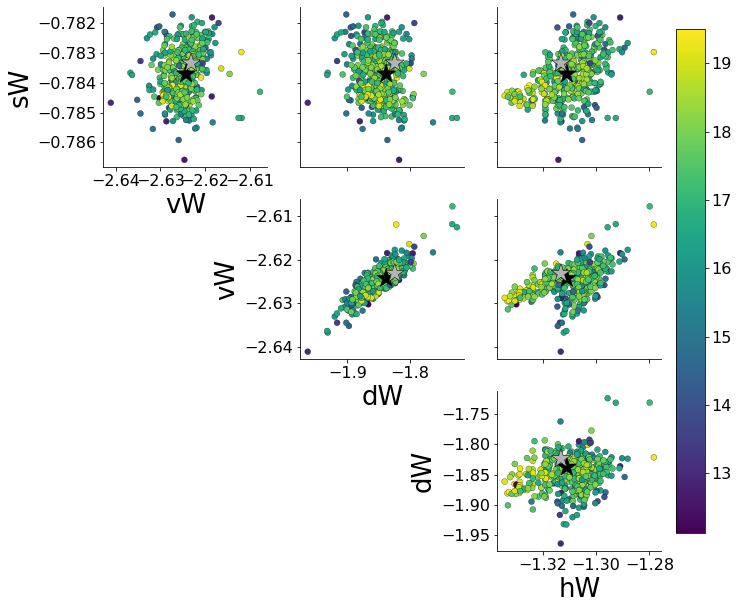

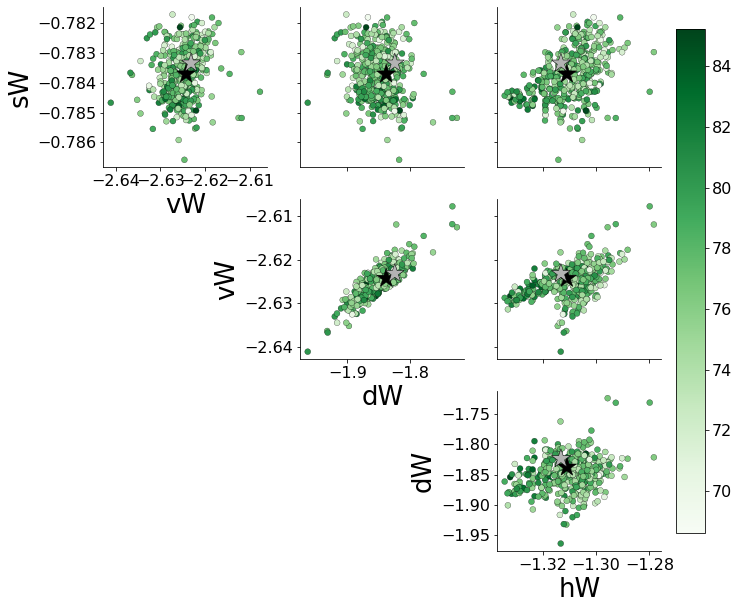

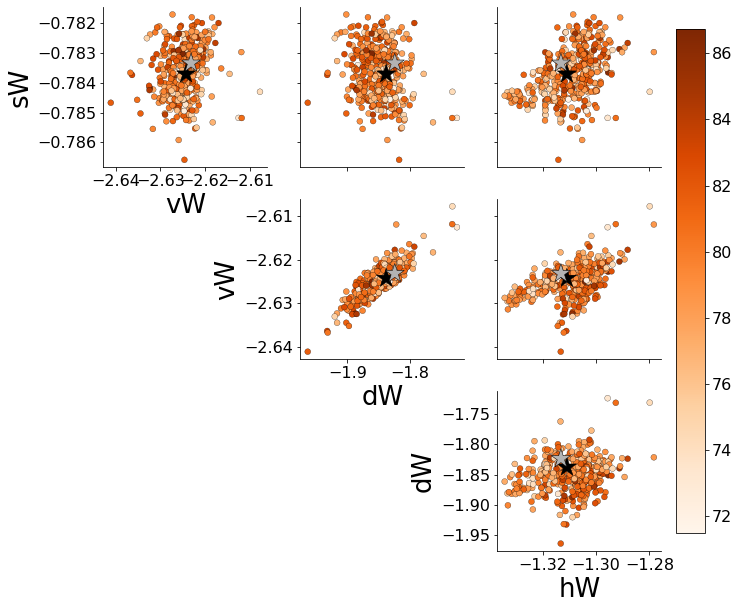

In [7]:
    
cmap_g = plt.get_cmap('Greens')
cmap_o = plt.get_cmap('Oranges')


fig = pairplot(z_plot, np.arange(4), z_labels, starred=z_stars, c_starred=c_stars, 
               fontsize=26, figsize=(10,10), ticksize=16, s=35,
               c=log_q_z_plot)
plt.savefig(os.path.join(figdir, "SC_EPI_logqz.pdf"))

fig = pairplot(z_plot, np.arange(4), z_labels, starred=z_stars, c_starred=c_stars, 
               fontsize=26, figsize=(10,10), ticksize=16, cmap=cmap_g, s=35,
               c=100*T_x_plot[:,0])
plt.savefig(os.path.join(figdir, "SC_EPI_pP.pdf"))

fig = pairplot(z_plot, np.arange(4), z_labels, starred=z_stars, c_starred=c_stars, 
               fontsize=26, figsize=(10,10), ticksize=16, cmap=cmap_o, s=35,
               c=100*(1.-T_x_plot[:,1]))
plt.savefig(os.path.join(figdir, "SC_EPI_pA.pdf"))

In [8]:
mode_ind = np.argmax(log_q_z_plot)
z_mode = z_plot[mode_ind][None,:]

hess_z = dist.hessian(z_mode)[0]

In [9]:
print(dist.log_prob(z_mode))

[19.520382]


-2504937000.0 [-0.9413369   0.328083   -0.01611799 -0.07737235]


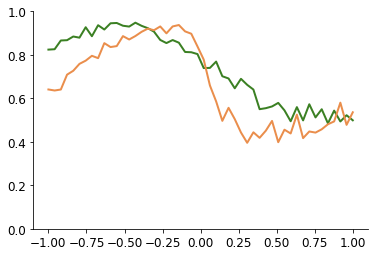

-5748104.0 [ 0.33379564  0.8717969  -0.03738447 -0.3565852 ]


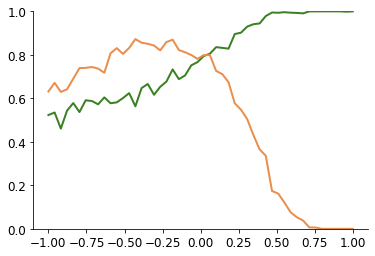

-585.67633 [0.03256141 0.27897477 0.71761084 0.6372971 ]


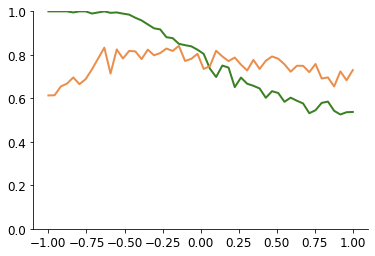

1561.9674 [ 0.03748289  0.2334625  -0.69525343  0.6787584 ]


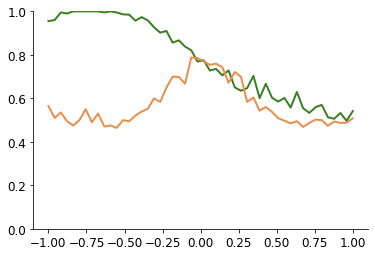

In [10]:
w, v = np.linalg.eigh(hess_z)

alphas = np.linspace(-1, 1, 50)[:,None].astype(np.float32)
for i, _w in enumerate(w):
    v_i = v[:,i]
    print(_w, v_i)
    z_perturb = z_mode + alphas*v_i[None,:]
    T_x_perturb = model.eps(z_perturb)
    p_P_perturb = T_x_perturb[:,0]
    p_A_perturb = 1. - T_x_perturb[:,1]
    
    plt.figure()
    plt.plot(alphas, p_P_perturb, c=c_LP)
    plt.plot(alphas, p_A_perturb, c=c_LA)
    plt.ylim([0., 1.])
    plt.show()


75.1, 71.5


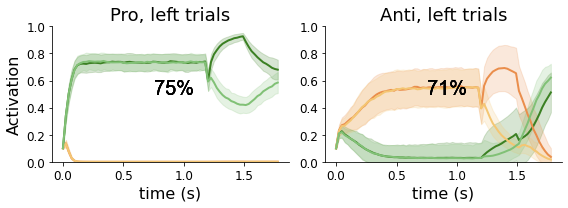

77.1, 80.0


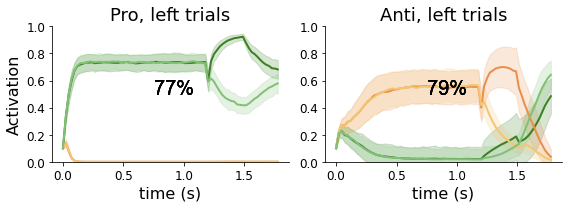

In [11]:
v_t_stars = np.stack([v_t_plot[:,ind,:,:,:] for ind in z_star_inds], axis=1)
T_x_stars = np.stack([T_x_plot[ind,:] for ind in z_star_inds], axis=0)

t_cue_delay = 1.2
t_choice = 0.3
t_post_choice = 0.3
t_total = t_cue_delay + t_choice + t_post_choice
dt = 0.024
t = np.arange(0.0, t_total, dt)
T = t.shape[0]

percfont = {'family': 'arial',
            'weight': 'light',
            'size': 20,
        }
neuron_labels = ['LP', 'LA', 'RA', 'RP']
colors = [c_LP, c_LA, c_RA, c_RP]
C_titles = ['Pro, left trials', 'Anti, left trials']
for m in range(len(z_stars)):
    print("%.1f, %.1f" % (100*T_x_stars[m,0], 100-100*T_x_stars[m,1]))
    fig, axs = plt.subplots(1,2,figsize=(8, 3))
    for c in range(2):
        for i in range(4):
            mean_v = np.mean(v_t_stars[:,m,c,i,:], axis=1)
            std_v = np.std(v_t_stars[:,m,c,i,:], axis=1)
            axs[c].fill_between(t, mean_v - std_v, mean_v + std_v, color=colors[i], alpha=0.2)
            axs[c].plot(t, mean_v, label=neuron_labels[i], c=colors[i])
            axs[c].set_title(C_titles[c])
            axs[c].set_ylim([0,1])
            if c == 0:
                axs[c].text(0.75, 0.5, '%2d%%' % (100.*T_x_stars[m,c]), fontdict=percfont)
            else:
                axs[c].text(0.75, 0.5, '%2d%%' % (100.*(1.-T_x_stars[m,c])), fontdict=percfont)
        axs[c].set_xlabel('time (s)')
    axs[0].set_ylabel('Activation')
        
    plt.tight_layout()
    plt.savefig(os.path.join(figdir, "sim%d.pdf" % (m+1)))
    plt.show()

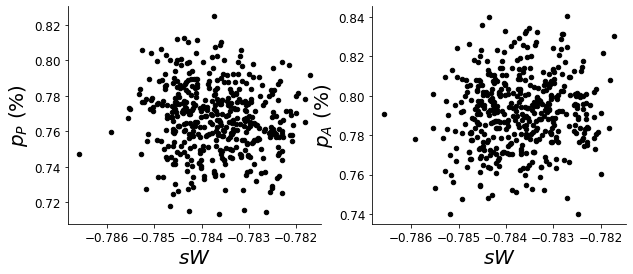

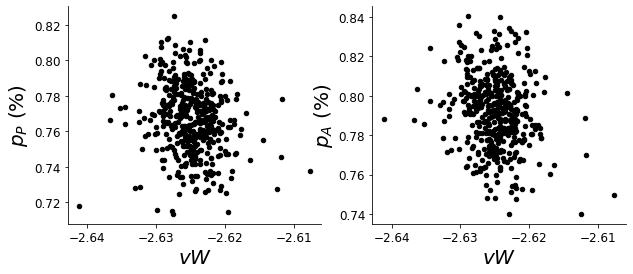

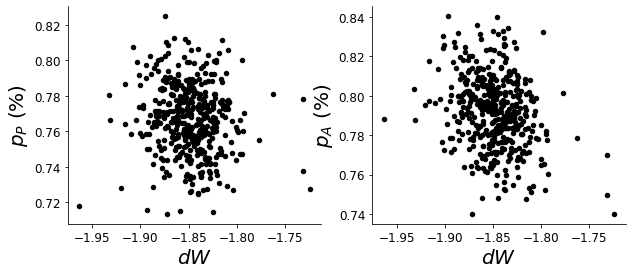

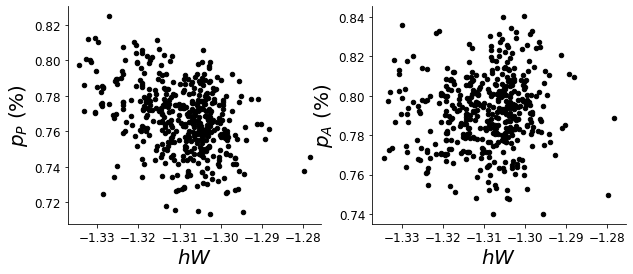

In [12]:
T_x_plot = SC_acc(*unwrap(z_plot))

sW = z_plot[:,0]
vW = z_plot[:,1]
dW = z_plot[:,2]
hW = z_plot[:,3]
pP = T_x_plot[:,0]
pA = 1. - T_x_plot[:,1]

def plot_p_corrs(x, xlabel, pP, pA, c=None, fontsize=None):
    if c is None:
        c = 'k'
    if fontsize is None:
        fontsize = 20
    fig, axs = plt.subplots(1,2,figsize=(10,4))
    axs[0].scatter(x, pP, s=20, c=c)
    axs[0].set_xlabel(xlabel, fontsize=fontsize)
    axs[0].set_ylabel(r'$p_P$ (%)', fontsize=fontsize)
    axs[1].scatter(x, pA, s=20, c=c)
    axs[1].set_xlabel(xlabel, fontsize=fontsize)
    axs[1].set_ylabel(r'$p_A$ (%)', fontsize=fontsize)
    
    
plot_p_corrs(sW, r'$sW$', pP, pA)
plot_p_corrs(vW, r'$vW$', pP, pA)
plot_p_corrs(dW, r'$dW$', pP, pA)
plot_p_corrs(hW, r'$hW$', pP, pA)

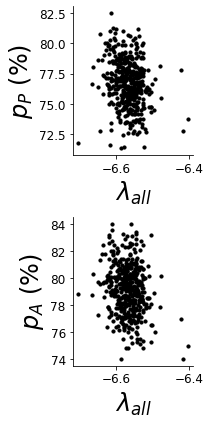

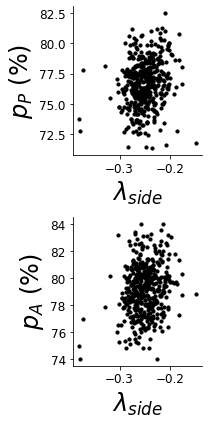

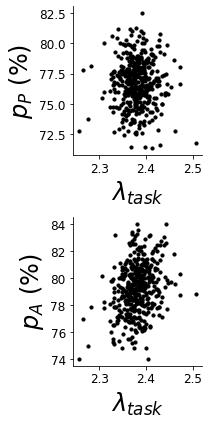

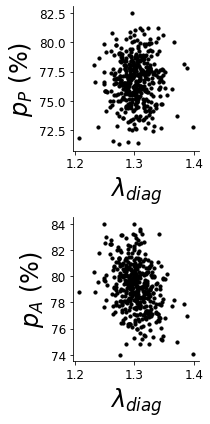

In [13]:
Wrow1 = tf.stack([sW, vW, dW, hW], axis=1)
Wrow2 = tf.stack([vW, sW, hW, dW], axis=1)
Wrow3 = tf.stack([dW, hW, sW, vW], axis=1)
Wrow4 = tf.stack([hW, dW, vW, sW], axis=1)

W = tf.stack([Wrow1, Wrow2, Wrow3, Wrow4], axis=1)

def get_schur_eigs(W):
    # returns 
    T, Z = scipy.linalg.schur(W)
    b = Z.copy()
    b[b<0.0] = -1
    b[b>0.0] = 1
    modes = 0.25*np.array([[1.0, 1.0, 1.0, 1.0],   # all mode
                          [-1.0, -1.0, 1.0, 1.0], # side mode
                          [1.0, -1.0, -1.0, 1.0], # task mode
                          [-1.0, 1.0, -1.0, 1.0]]) # diag mode
    X = np.abs(np.dot(modes,b))  # (template_mode x z_col)
    eigs = np.zeros((4,))
    for i in range(4):
        z_ind = np.argmax(X[i] == 1.0)
        eigs[i] = T[z_ind, z_ind]
    return eigs

eigs = np.array([get_schur_eigs(W[i]) for i in range(sW.shape[0])])

def plot_p_corrs(x, xlabel, pP, pA, c=None, fontsize=None):
    if c is None:
        c = 'k'
    if fontsize is None:
        fontsize = 20
    fig, axs = plt.subplots(2,1,figsize=(3,6))
    axs[0].scatter(x, 100*pP, s=10, c=c)
    axs[0].set_xlabel(xlabel, fontsize=fontsize)
    axs[0].set_ylabel(r'$p_P$ (%)', fontsize=fontsize)
    axs[1].scatter(x, 100*pA, s=10, c=c)
    axs[1].set_xlabel(xlabel, fontsize=fontsize)
    axs[1].set_ylabel(r'$p_A$ (%)', fontsize=fontsize)
    
eig_names = ['all', 'side', 'task', 'diag']
for i, eig_name in enumerate(eig_names):
    plot_p_corrs(eigs[:,i], r'$\lambda_{%s}$' % eig_name, pP, pA, fontsize=24)
    plt.tight_layout()
    plt.savefig(os.path.join(figdir, "lambda_%s.pdf" % eig_name))

70.0, 74.5


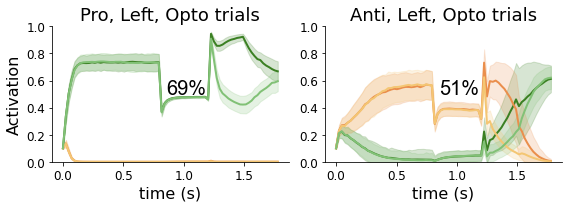

74.1, 75.4


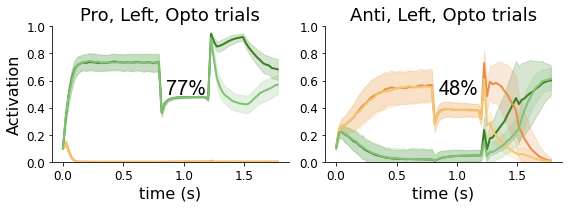

In [14]:
u_t, v_t_stars = SC_sim_opto(*unwrap(z_stars))
T_x_stars = np.mean(expit(100.*(v_t_stars[-1,:,:,0,:] - v_t_stars[-1,:,:,3,:])), axis=2)

t_cue_delay = 1.2
t_choice = 0.3
t_post_choice = 0.3
t_total = t_cue_delay + t_choice + t_post_choice
dt = 0.024
t = np.arange(0.0, t_total, dt)
T = t.shape[0]

neuron_labels = ['LP', 'LA', 'RA', 'RP']
colors = [c_LP, c_LA, c_RA, c_RP]
C_titles = ['Pro, Left trials', 'Anti, Left trials',
            'Pro, Left, Opto trials', 'Anti, Left, Opto trials']
for m in range(len(z_stars)):
    print("%.1f, %.1f" % (100*T_x_stars[m,0], 100-100*T_x_stars[m,1]))
    fig, axs = plt.subplots(1,2,figsize=(8, 3))
    for c in range(2,4):
        for i in range(4):
            mean_v = np.mean(v_t_stars[:,m,c,i,:], axis=1)
            std_v = np.std(v_t_stars[:,m,c,i,:], axis=1)
            axs[c-2].fill_between(t, mean_v - std_v, mean_v + std_v, color=colors[i], alpha=0.2)
            axs[c-2].plot(t, mean_v, label=neuron_labels[i], c=colors[i])
            axs[c-2].set_title(C_titles[c])
            axs[c-2].set_ylim([0,1])
        axs[c-2].set_xlabel('time (s)')
        if c == 2:
            axs[c-2].text(0.85, 0.5, '%2d%%' % (100.*T_x_stars[m,c]), fontdict=percfont)
        else:
            axs[c-2].text(0.85, 0.5, '%2d%%' % (100.*(1.-T_x_stars[m,c])), fontdict=percfont)
        
    axs[0].set_ylabel('Activation')
        
    plt.tight_layout()
    plt.savefig(os.path.join(figdir, "opto_sim%d.pdf" % (m+1)))
    plt.show()

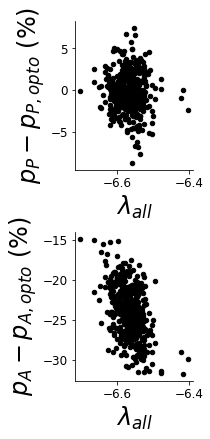

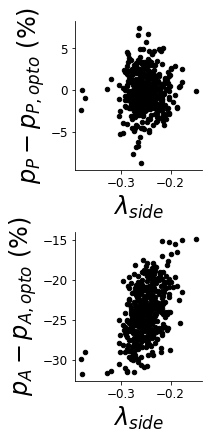

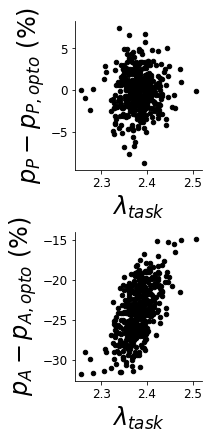

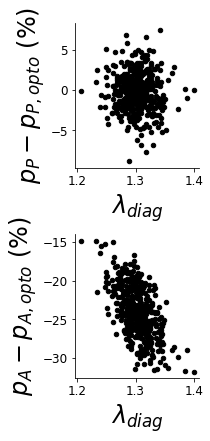

In [15]:
def plot_diff_corrs(x, xlabel, diff1, diff2, c=None, fontsize=None):
    if c is None:
        c = 'k'
    if fontsize is None:
        fontsize = 20
    fig, axs = plt.subplots(2,1,figsize=(3,6))
    axs[0].scatter(x, diff1, s=20, c=c)
    axs[0].set_xlabel(xlabel, fontsize=fontsize)
    axs[0].set_ylabel(r'$p_P-p_{P,opto}$ (%)', fontsize=fontsize)
    axs[1].scatter(x, diff2, s=20, c=c)
    axs[1].set_xlabel(xlabel, fontsize=fontsize)
    axs[1].set_ylabel(r'$p_A-p_{A,opto}$ (%)', fontsize=fontsize)
    
T_x2 = SC_acc_diff(*unwrap(z_plot))
for i, eig_name in enumerate(eig_names):
    plot_diff_corrs(eigs[:,i], r'$\lambda_{%s}$' % eig_name, 100*T_x2[:,0], 100*T_x2[:,1], fontsize=24)
    plt.tight_layout()
    plt.savefig(os.path.join(figdir, "lambda_opto_%s.pdf" % eig_name))